
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ab-test-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2479030%2F4213024%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240330%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240330T225425Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5f0b86438c0438cdc8ee57c072f48e97fdd4d00520b3ba0f962fb3a7a3578c8f1e855972d2ca87b7dd961d5a62208d7b1407eeb74c7d2a2ed84bcaf1e412e953dc50c86a235fb926ad19af56a7c16ee4a06171c7c33d131b9a2ad6235532a9b454c3f278b72fbd7178fdddaf2e591292c477c9e2bd0a8483b31158c306207a768d97e67bb867139040d8978221a23dd793dd104cc3d85f2e09a7742959d6985e9a7df62e3cc561e1752eac2ec707517e5ec8ad98baaee327e8c3eec01b414d8202bf6ea940cbab62cce4dfef5bf0bc262976b2d3f150eee8835f58f7306037ccc81c48189acb74cae0f45ecab679039f649b7819e1e1820d1f67937886264707'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [7]:
path = 'AB_Test_Results.csv'
df = pd.read_csv(path)

In [8]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [10]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [11]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Let's see if there are users who have two A/B test groups

In [13]:
# TODO : Look at the distribution of the number of unique groups for each user
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

In [14]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
double_variant_count / double_variant_count.sum()

VARIANT_NAME
1    0.756325
2    0.243675
Name: count, dtype: float64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


What can you observe ? Should we exclude these users ? Why ?

We see that there are users who have two ab test groups and they re 24% . We need to exclude them, because otherwise the effect of changes in the experiment will be blurred

In [18]:
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0]

4783

In [19]:
# TODO : users have 1 A/B test group ?
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)

# TODO : Take only these users
single_variant_users = single_variant_users[single_variant_users]
df2 = df[df['USER_ID'].isin(single_variant_users.index)]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6070 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       6070 non-null   int64  
 1   VARIANT_NAME  6070 non-null   object 
 2   REVENUE       6070 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 189.7+ KB


In [20]:
single_variant_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)
single_variant_users = single_variant_users[single_variant_users]

df = df[df['USER_ID'].isin(single_variant_users.index)]
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

In [21]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
4,6174,variant,0.0
5,2380,variant,0.0
7,9168,control,0.0
9,7548,control,0.0


In [22]:
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts().iloc[0] == double_variant_count.iloc[0]

True

In [23]:
# TODO : Leave only records with users with the 1st ab test group
df_1 = df[df['VARIANT_NAME']== 'variant']
# TODO : Check that the number of users matches what it was before the exception
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3044 entries, 0 to 9996
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       3044 non-null   int64  
 1   VARIANT_NAME  3044 non-null   object 
 2   REVENUE       3044 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 95.1+ KB


In [24]:
df_2 = df[df['VARIANT_NAME']== 'control']
# TODO : Check that the number of users matches what it was before the exception
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3026 entries, 7 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       3026 non-null   int64  
 1   VARIANT_NAME  3026 non-null   object 
 2   REVENUE       3026 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 94.6+ KB


Let's see how the data is distributed

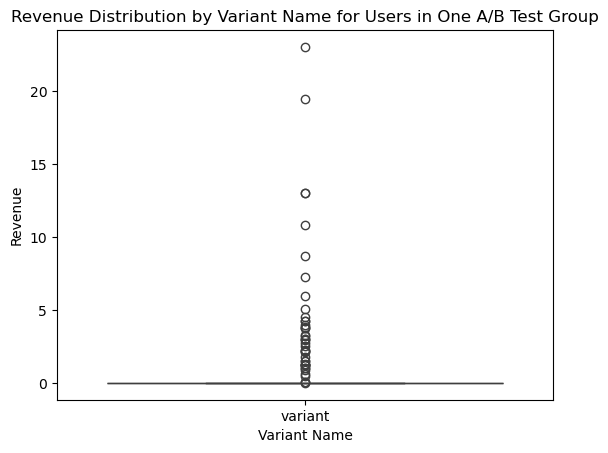

In [26]:
# TODO : Check how the data is distributed using a box plot
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'single_group_users' is the DataFrame with users in only one A/B test group
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df_1)

# Set title and labels
plt.title('Revenue Distribution by Variant Name for Users in One A/B Test Group')
plt.xlabel('Variant Name')
plt.ylabel('Revenue')

# Show the plot
plt.show()

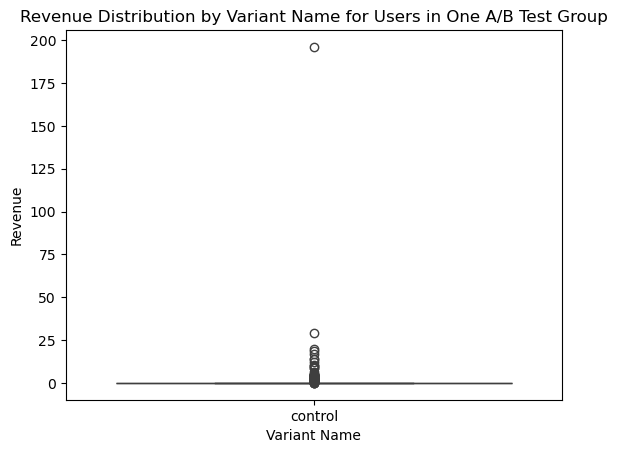

In [27]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df_2)

# Set title and labels
plt.title('Revenue Distribution by Variant Name for Users in One A/B Test Group')
plt.xlabel('Variant Name')
plt.ylabel('Revenue')

# Show the plot
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [29]:
# TODO : Sort these revenue values in descending order
df_2.sort_values(by = 'REVENUE', ascending = False)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
6412,1053,control,20.07
5530,282,control,18.56
758,4445,control,17.05
...,...,...,...
3406,3636,control,0.00
3408,1782,control,0.00
3411,5292,control,0.00
3412,7694,control,0.00


In [30]:
# TODO : See if user 3342 had other events with a strong outlier
df_2[df_2['USER_ID']== 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

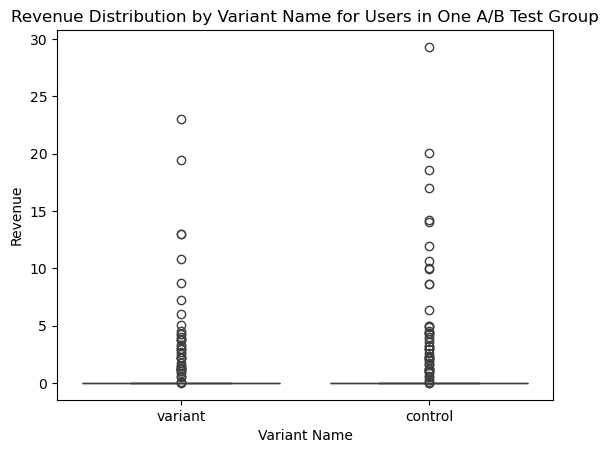

In [32]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.
df= df[df['USER_ID'] != 3342]
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

# Set title and labels
plt.title('Revenue Distribution by Variant Name for Users in One A/B Test Group')
plt.xlabel('Variant Name')
plt.ylabel('Revenue')

# Show the plot
plt.show()


What can you say about the users and their purchases ?

In [34]:
# TODO : Check if there are users who have records with zero and positive revenue
#users_with_zero_revenue = df[df['REVENUE'] == 0]['USER_ID']

# Users with positive revenue
#users_with_positive_revenue = df[df['REVENUE'] > 0]['USER_ID']
(df.loc[
    (df['REVENUE'] == 0) & (df['USER_ID'].isin(df.loc[df['REVENUE'] > 0, 'USER_ID'].values)), 
    'USER_ID'
]).count()

52

Can a user have records with both zero and positive revenue ?
  
  Yes  
  
Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [36]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

In [37]:
# TODO : Visualize the resulting distribution of the data again.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       4782 non-null   int64  
 1   VARIANT_NAME  4782 non-null   object 
 2   REVENUE       4782 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 112.2+ KB


In [38]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0


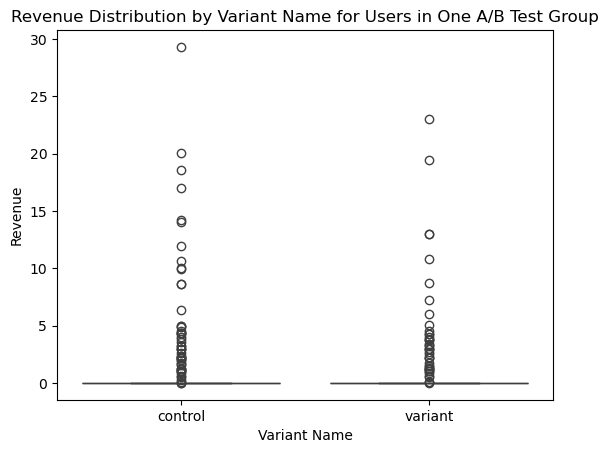

In [39]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)

# Set title and labels
plt.title('Revenue Distribution by Variant Name for Users in One A/B Test Group')
plt.xlabel('Variant Name')
plt.ylabel('Revenue')

# Show the plot
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [41]:
# TODO : get metrics by groups

all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})
# TODO : create two additional metrics to see relative changes


# TODO : add them to the rest of the metrics in a separate group
all_stat

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control         2389  274.55  0.114923    0.0  2389
variant         2393  179.32  0.074935    0.0  2393

What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4782 entries, 0 to 4781
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       4782 non-null   int64  
 1   VARIANT_NAME  4782 non-null   object 
 2   REVENUE       4782 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 112.2+ KB


In [44]:
# TODO : get metrics by groups
df_filtered = df[df['REVENUE'] > 0]


all_stat2 = df_filtered.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})


all_stat2

USER_ID REVENUE                       
             nunique     sum      mean median count
VARIANT_NAME                                       
control           53  274.55  5.180189   2.99    53
variant           42  179.32  4.269524   2.97    42

Let's look at the distributions of all and only paying users

C:\Users\Olga_hp\AppData\Local\Temp\ipykernel_5392\4101851425.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
C:\Users\Olga_hp\AppData\Local\Temp\ipykernel_5392\4101851425.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



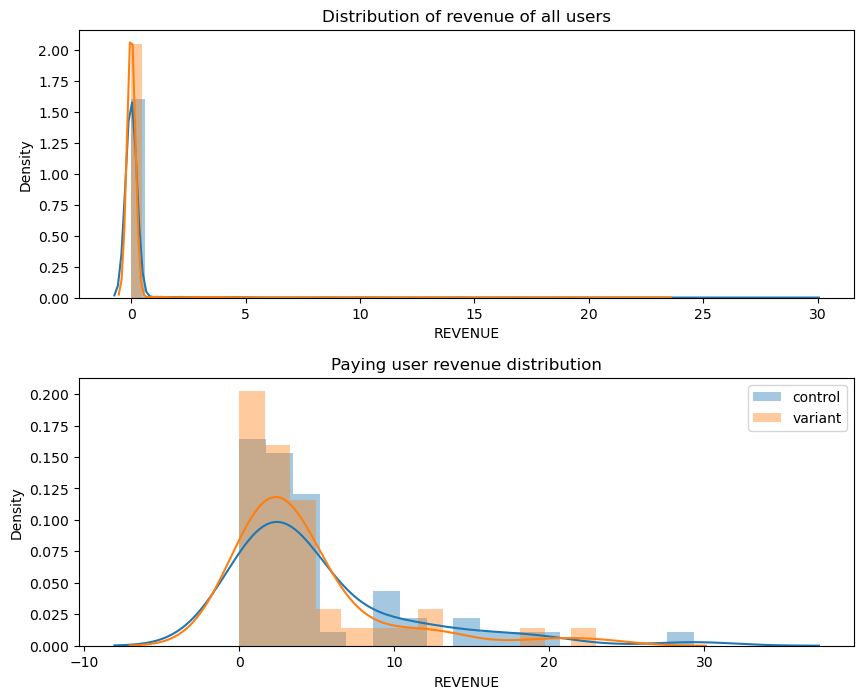

In [46]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [50]:
# TODO : Use the Shapiro-Wilk criterion to confirm it

from scipy import stats



# Select the 'REVENUE' column for the test
revenue_data_control = df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE']

# Perform the Shapiro-Wilk test
statistic, p_value = stats.shapiro(revenue_data_control)

# Display the test statistic and p-value
print(f'Shapiro-Wilk Test Statistic: {statistic}')
print(f'P-Value: {p_value}')

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print('The data is not normally distributed (reject H0)')
else:
    print('The data is normally distributed (fail to reject H0)')


Shapiro-Wilk Test Statistic: 0.7512773147130261
P-Value: 4.129931913160037e-08
The data is not normally distributed (reject H0)


In [51]:
# Select the 'REVENUE' column for the test
revenue_data_variant = df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE']

# Perform the Shapiro-Wilk test
statistic, p_value = stats.shapiro(revenue_data_variant)

# Display the test statistic and p-value
print(f'Shapiro-Wilk Test Statistic: {statistic}')
print(f'P-Value: {p_value}')

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print('The data is not normally distributed (reject H0)')
else:
    print('The data is normally distributed (fail to reject H0)')


Shapiro-Wilk Test Statistic: 0.7135707895039944
P-Value: 9.88901135571282e-08
The data is not normally distributed (reject H0)


Is the null hypothesis about the normal distribution of the data rejected ?

The data is not normally distributed. The very small p-value suggests that the deviation from normality is significant, confirming that the data does not follow a normal distribution..  Since the p-value is much smaller than the typical significance level of 0.05, it indicates that there is strong evidence against the null hypothesis.

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [56]:
(df['REVENUE'] == 0).value_counts()

REVENUE
True     4687
False      95
Name: count, dtype: int64

In [57]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
revenue_A = df[df['VARIANT_NAME'] == 'variant']['REVENUE']
revenue_B = df[df['VARIANT_NAME'] == 'control']['REVENUE']

# Perform the Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(revenue_A, revenue_B, alternative='two-sided')

# Display the results
print(f'Mann-Whitney U Test Statistic: {statistic}')
print(f'P-Value: {p_value}')

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference between the two groups.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference between the two groups.')

Mann-Whitney U Test Statistic: 2845109.0
P-Value: 0.24799555106821947
Fail to reject the null hypothesis: There is no significant difference between the two groups.


In [58]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
revenue_A_pay = df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE']
revenue_B_pay = df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE']

# Perform the Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(revenue_A, revenue_B, alternative='two-sided')

# Display the results
print(f'Mann-Whitney U Test Statistic: {statistic}')
print(f'P-Value: {p_value}')

# Interpretation of the result
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference between the two groups.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference between the two groups.')

Mann-Whitney U Test Statistic: 2845109.0
P-Value: 0.24799555106821947
Fail to reject the null hypothesis: There is no significant difference between the two groups.


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [61]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [62]:
# TODO : Generate samples for all users

In [63]:
# TODO : Generate samples for only paying users

Let's look at the distribution of means in the ab test groups

NameError: name 'control' is not defined

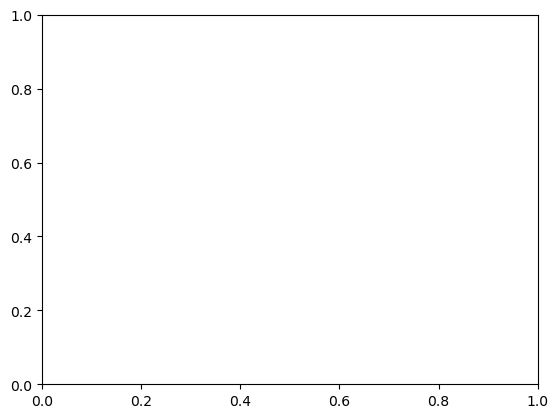

In [65]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

In [ ]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [ ]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.
